In [256]:
from PIL import Image
import os
import cv2

dir_path_1 = 'datasets/Cyrillic/Ш'
list_of_files_1 = os.listdir(dir_path_1)
number_of_pictures_1 = len(list_of_files_1)
for png in list_of_files_1:
    im = Image.open(dir_path_1 + '/' + png)
    size = (44, 48)
    out = im.resize(size)
    out.save('datasets/chars_1/' + png)

dir_path_2 = 'datasets/Cyrillic/Г'
list_of_files_2 = os.listdir(dir_path_2)
number_of_pictures_2 = len(list_of_files_2)
for png in list_of_files_2:
    im = Image.open(dir_path_2 + '/' + png)
    size = (44, 48)
    out = im.resize(size)
    out.save('datasets/chars_2/' + png)



In [257]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

In [258]:
dir_chars_1 = "datasets/chars_1"
dir_chars_2 = "datasets/chars_2"

train_filenames_1 = os.listdir(dir_chars_1)
train_filenames_2 = os.listdir(dir_chars_2)

number_of_char_1 = len(train_filenames_1)
number_of_char_2 = len(train_filenames_2)

x_class1 = np.empty([number_of_char_1, 2112])
x_class2 = np.empty([number_of_char_2, 2112])

y_class1 = np.empty(number_of_char_1)
y_class2 = np.empty(number_of_char_2)

for i in range(number_of_char_1):
    if not train_filenames_1[i].startswith("."):
        image = cv2.imread(dir_chars_1 + '/' + train_filenames_1[i])
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pixels_line = (np.asarray(grayImage).flatten() / 255).astype(np.float32)
        x_class1[i] = pixels_line
        y_class1[i] = 0
for i in range(number_of_char_2):
    if not train_filenames_2[i].startswith("."):
        image = cv2.imread(dir_chars_2 + '/' + train_filenames_2[i])
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pixels_line = (np.asarray(grayImage).flatten() / 255).astype(np.float32)
        x_class2[i] = pixels_line
        y_class2[i] = 1

print(x_class1.shape, x_class2.shape)
print(y_class1.shape, y_class2.shape)

(432, 2112) (425, 2112)
(432,) (425,)


In [259]:
X = np.concatenate([x_class1, x_class2])
y = np.concatenate([y_class1, y_class2])
print(X.shape)
print(y.shape)

(857, 2112)
(857,)


In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train[2]

(685, 2112) (172, 2112) (685,) (172,)


0.0

In [261]:
y_train = np.array([[1 if i == y_train[j] else 0 for i in range(2)] for j in range(len(y_train))])
y_test = np.array([[1 if i == y_test[j] else 0 for i in range(2)] for j in range(len(y_test))])
print(y_train[0])

[0 1]


In [262]:
def sigmoid(x, derivative=False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1 / (1 + np.exp(-x))

In [263]:
def nn_init(lsize):
    input_layer = lsize[0]
    hidden_1 = lsize[1]
    hidden_2 = lsize[2]
    output_layer = lsize[3]

    # narrowing down the standard deviation by layer size, with np.sqrt()
    # large layers have tighter initial values
    nnet = {
        'w0': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'w1': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'w2': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
    return nnet

In [264]:
def softmax(x, derivative=False):
    # for stability, we shift values down so max = 0
    # https://cs231n.github.io/linear-classify/#softmax
    exp_shifted = np.exp(x - x.max())
    if derivative:
        return exp_shifted / np.sum(exp_shifted, axis=0) * (1 - exp_shifted / np.sum(exp_shifted, axis=0))
    else:
        return exp_shifted / np.sum(exp_shifted, axis=0)

In [265]:
def forward_pass(x):
    # the model is a global var, used here read-only

    # NN state: internal sums, neuron outputs
    nn_state = {}

    # "output zero" is the output from receptors = input to first layer in the NN
    # these are activations for the input layer
    nn_state['o0'] = x

    # from input layer to hidden layer 1
    # weighted sum of all activations, then sigmoid
    nn_state['z1'] = np.dot(model['w0'], nn_state['o0'])
    nn_state['o1'] = sigmoid(nn_state['z1'])

    # from hidden 1 to hidden 2
    nn_state['z2'] = np.dot(model['w1'], nn_state['o1'])
    nn_state['o2'] = sigmoid(nn_state['z2'])

    # from hidden 2 to output
    nn_state['z3'] = np.dot(model['w2'], nn_state['o2'])
    nn_state['o3'] = softmax(nn_state['z3'])

    return nn_state

In [266]:
def part_cost(o, y):
    cost = 0
    for i in range(len(y)):
        cost += y[i] * np.log(o[i]) + (1 - y[i]) * np.log(1 - o[i])
    # for i in range(len(y)):
    #     cost += y[i] * np.log(o[i]) + (1 - y[i]) * np.log(1 - o[i])

    #     c = np.dot(y, np.log(o)) + np.dot((1 - y), np.log(1 - o))
    return -cost

In [267]:
def backward_pass(x, y):
    # do the forward pass, register the state of the network
    nn_state = forward_pass(x)

    # small deltas: derivatives of the error w.r.t. z
    nn_state['d3'] = nn_state['o3'] - y
    nn_state['d2'] = np.dot(nn_state['d3'], model['w2']) * softmax(nn_state['z2'], derivative=True)
    nn_state['d1'] = np.dot(nn_state['d2'], model['w1']) * sigmoid(nn_state['z1'], derivative=True)

    # large deltas: adjustments to weights
    nn_state['D2'] = np.outer(nn_state['d3'], nn_state['o2'])
    nn_state['D1'] = np.outer(nn_state['d2'], nn_state['o1'])
    nn_state['D0'] = np.outer(nn_state['d1'], nn_state['o0'])

    return nn_state

In [282]:
layer_sizes = [2112, 256, 128, 2]
model = nn_init(layer_sizes)

In [283]:
print(len(y_train))
print(y_train)

685
[[0 1]
 [0 1]
 [1 0]
 ...
 [0 1]
 [1 0]
 [0 1]]


In [284]:
epochs = 100

t_rate = 0.02
# t_rate = 0.01
# t_rate_decrease = 0.7
# t_rate_increase = 1.05
# error_increase_lim = 1.04
# prev_cost = 0

costs = []
accuracies = []

epoch = 0

print('################### training ####################')
for e in tqdm(range(epochs)):
    epoch += 1
    print('\nepoch:', epoch)
    # while accuracy != 1.0:
    #     print('epoch:', e)

    samples = X_train.shape[0]
    cost = 0
    hit_count = 0

    for i in range(samples):
        # print(X_train[i])
        m_state = backward_pass(X_train[i], y_train[i])
        # add partial cost
        #         print(m_state['o3'], y_train[i])
        cost += part_cost(m_state['o3'], y_train[i])
        #         print(cost)

        # stochastic gradient descent update weights
        model['w0'] -= t_rate * m_state['D0']
        model['w1'] -= t_rate * m_state['D1']
        model['w2'] -= t_rate * m_state['D2']

        if np.argmax(m_state['o3']) == np.argmax(y_train[i]):
            hit_count += 1

    #update t_rate
    # if cost > error_increase_lim * prev_cost:
    #     t_rate *= t_rate_decrease
    # else:
    #     t_rate *= t_rate_increase
    #
    # prev_cost = cost

    print('cost = ', cost)
    print('accuracy = ', accuracy)
    # performance evaluation
    cost = cost / samples
    accuracy = hit_count / samples
    costs.append(cost)
    accuracies.append(accuracy)
    #print('cost:', cost, 'accuracy:', accuracy)

total_cost = cost
total_accuracy = accuracy
print('total_cost, total_accuracy')
print(total_cost, total_accuracy)

# save the model
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

  0%|          | 0/500 [00:00<?, ?it/s]

################### training ####################

epoch: 1


  0%|          | 1/500 [00:01<15:43,  1.89s/it]

cost =  1513.8917348975656
accuracy =  0.5174418604651163

epoch: 2


  0%|          | 2/500 [00:03<15:38,  1.88s/it]

cost =  1360.8480299153528
accuracy =  0.5109489051094891

epoch: 3


  1%|          | 3/500 [00:05<14:35,  1.76s/it]

cost =  1261.1048238630935
accuracy =  0.5124087591240876

epoch: 4


  1%|          | 4/500 [00:06<13:24,  1.62s/it]

cost =  1193.5643045961397
accuracy =  0.5080291970802919

epoch: 5


  1%|          | 5/500 [00:07<12:25,  1.51s/it]

cost =  1145.6211497202296
accuracy =  0.5197080291970803

epoch: 6


  1%|          | 6/500 [00:09<12:06,  1.47s/it]

cost =  1110.2891748141392
accuracy =  0.5240875912408759

epoch: 7


  1%|▏         | 7/500 [00:10<11:53,  1.45s/it]

cost =  1083.4770450724034
accuracy =  0.5299270072992701

epoch: 8


  2%|▏         | 8/500 [00:11<11:26,  1.40s/it]

cost =  1062.653848760647
accuracy =  0.5386861313868613

epoch: 9


  2%|▏         | 9/500 [00:13<11:06,  1.36s/it]

cost =  1046.179649605343
accuracy =  0.5357664233576642

epoch: 10


  2%|▏         | 10/500 [00:14<10:57,  1.34s/it]

cost =  1032.9488567597764
accuracy =  0.5416058394160584

epoch: 11


  2%|▏         | 11/500 [00:17<14:45,  1.81s/it]

cost =  1022.1902777400275
accuracy =  0.5372262773722628

epoch: 12


  2%|▏         | 12/500 [00:18<13:52,  1.71s/it]

cost =  1013.3500217622822
accuracy =  0.5343065693430656

epoch: 13


  3%|▎         | 13/500 [00:20<14:36,  1.80s/it]

cost =  1006.020231404654
accuracy =  0.5343065693430656

epoch: 14


  3%|▎         | 14/500 [00:22<13:31,  1.67s/it]

cost =  999.8941858228062
accuracy =  0.5299270072992701

epoch: 15


  3%|▎         | 15/500 [00:24<15:47,  1.95s/it]

cost =  994.7371210830979
accuracy =  0.5372262773722628

epoch: 16


  3%|▎         | 16/500 [00:26<14:36,  1.81s/it]

cost =  990.3667122889992
accuracy =  0.5401459854014599

epoch: 17


  3%|▎         | 17/500 [00:27<13:13,  1.64s/it]

cost =  986.6396609934486
accuracy =  0.5416058394160584

epoch: 18


  4%|▎         | 18/500 [00:28<11:47,  1.47s/it]

cost =  983.4422395518855
accuracy =  0.5328467153284672

epoch: 19


  4%|▍         | 19/500 [00:29<10:55,  1.36s/it]

cost =  980.6834635793874
accuracy =  0.5357664233576642

epoch: 20


  4%|▍         | 20/500 [00:30<09:58,  1.25s/it]

cost =  978.2900534156505
accuracy =  0.5313868613138686

epoch: 21


  4%|▍         | 21/500 [00:31<09:18,  1.17s/it]

cost =  976.2026442818935
accuracy =  0.5328467153284672

epoch: 22


  4%|▍         | 22/500 [00:32<08:51,  1.11s/it]

cost =  974.3728900220465
accuracy =  0.5313868613138686

epoch: 23


  5%|▍         | 23/500 [00:33<08:30,  1.07s/it]

cost =  972.7612216680491
accuracy =  0.5240875912408759

epoch: 24


  5%|▍         | 24/500 [00:35<09:30,  1.20s/it]

cost =  971.3350961465178
accuracy =  0.5226277372262774

epoch: 25


  5%|▌         | 25/500 [00:36<10:21,  1.31s/it]

cost =  970.0676183859217
accuracy =  0.5153284671532846

epoch: 26


  5%|▌         | 26/500 [00:38<10:43,  1.36s/it]

cost =  968.9364517826548
accuracy =  0.5197080291970803

epoch: 27


  5%|▌         | 27/500 [00:39<11:41,  1.48s/it]

cost =  967.922953523059
accuracy =  0.5182481751824818

epoch: 28


  6%|▌         | 28/500 [00:41<11:49,  1.50s/it]

cost =  967.0114863649635
accuracy =  0.5211678832116788

epoch: 29


  6%|▌         | 29/500 [00:43<13:54,  1.77s/it]

cost =  966.1888694325813
accuracy =  0.5211678832116788

epoch: 30


  6%|▌         | 30/500 [00:45<14:19,  1.83s/it]

cost =  965.4439387601334
accuracy =  0.5240875912408759

epoch: 31


  6%|▌         | 31/500 [00:47<13:20,  1.71s/it]

cost =  964.7671945834592
accuracy =  0.5211678832116788

epoch: 32


  6%|▋         | 32/500 [00:48<11:43,  1.50s/it]

cost =  964.1505172582008
accuracy =  0.5226277372262774

epoch: 33


  7%|▋         | 33/500 [00:49<10:30,  1.35s/it]

cost =  963.5869375228511
accuracy =  0.5211678832116788

epoch: 34


  7%|▋         | 34/500 [00:50<09:36,  1.24s/it]

cost =  963.0704498609185
accuracy =  0.5182481751824818

epoch: 35


  7%|▋         | 35/500 [00:51<08:58,  1.16s/it]

cost =  962.5958601180246
accuracy =  0.5240875912408759

epoch: 36


  7%|▋         | 36/500 [00:52<08:32,  1.10s/it]

cost =  962.1586604259734
accuracy =  0.5226277372262774

epoch: 37


  7%|▋         | 37/500 [00:53<08:31,  1.10s/it]

cost =  961.7549259779827
accuracy =  0.5182481751824818

epoch: 38


  8%|▊         | 38/500 [00:54<09:51,  1.28s/it]

cost =  961.3812293692007
accuracy =  0.5167883211678832

epoch: 39


  8%|▊         | 39/500 [00:56<09:58,  1.30s/it]

cost =  961.0345691308147
accuracy =  0.5138686131386861

epoch: 40


  8%|▊         | 40/500 [00:57<09:58,  1.30s/it]

cost =  960.7123097983371
accuracy =  0.5124087591240876

epoch: 41


  8%|▊         | 41/500 [00:59<10:50,  1.42s/it]

cost =  960.4121314088861
accuracy =  0.5124087591240876

epoch: 42


  8%|▊         | 42/500 [01:00<11:05,  1.45s/it]

cost =  960.1319867532168
accuracy =  0.5153284671532846

epoch: 43


  9%|▊         | 43/500 [01:02<10:26,  1.37s/it]

cost =  959.8700650436305
accuracy =  0.5211678832116788

epoch: 44


  9%|▉         | 44/500 [01:03<09:41,  1.28s/it]

cost =  959.62476092061
accuracy =  0.5240875912408759

epoch: 45


  9%|▉         | 45/500 [01:04<09:10,  1.21s/it]

cost =  959.3946479259124
accuracy =  0.5197080291970803

epoch: 46


  9%|▉         | 46/500 [01:05<08:56,  1.18s/it]

cost =  959.1784557309512
accuracy =  0.5211678832116788

epoch: 47


  9%|▉         | 47/500 [01:06<08:50,  1.17s/it]

cost =  958.975050536923
accuracy =  0.5182481751824818

epoch: 48


 10%|▉         | 48/500 [01:07<08:27,  1.12s/it]

cost =  958.7834181646683
accuracy =  0.5167883211678832

epoch: 49


 10%|▉         | 49/500 [01:08<08:41,  1.16s/it]

cost =  958.602649433766
accuracy =  0.5182481751824818

epoch: 50


 10%|█         | 50/500 [01:09<08:32,  1.14s/it]

cost =  958.4319274961923
accuracy =  0.5182481751824818

epoch: 51


 10%|█         | 51/500 [01:11<09:04,  1.21s/it]

cost =  958.2705168434974
accuracy =  0.5153284671532846

epoch: 52


 10%|█         | 52/500 [01:12<09:31,  1.28s/it]

cost =  958.1177537504232
accuracy =  0.5153284671532846

epoch: 53


 11%|█         | 53/500 [01:13<09:22,  1.26s/it]

cost =  957.9730379541056
accuracy =  0.5138686131386861

epoch: 54


 11%|█         | 54/500 [01:14<09:01,  1.21s/it]

cost =  957.8358253982277
accuracy =  0.5167883211678832

epoch: 55


 11%|█         | 55/500 [01:16<09:20,  1.26s/it]

cost =  957.7056218965361
accuracy =  0.5182481751824818

epoch: 56


 11%|█         | 56/500 [01:17<09:28,  1.28s/it]

cost =  957.581977591417
accuracy =  0.5138686131386861

epoch: 57


 11%|█▏        | 57/500 [01:19<09:52,  1.34s/it]

cost =  957.4644821008816
accuracy =  0.5138686131386861

epoch: 58


 12%|█▏        | 58/500 [01:20<09:13,  1.25s/it]

cost =  957.3527602625106
accuracy =  0.5138686131386861

epoch: 59


 12%|█▏        | 59/500 [01:21<08:54,  1.21s/it]

cost =  957.2464683956662
accuracy =  0.5124087591240876

epoch: 60


 12%|█▏        | 60/500 [01:22<09:25,  1.29s/it]

cost =  957.1452910141932
accuracy =  0.5109489051094891

epoch: 61


 12%|█▏        | 61/500 [01:26<13:56,  1.90s/it]

cost =  957.0489379311363
accuracy =  0.5124087591240876

epoch: 62


 12%|█▏        | 62/500 [01:27<12:54,  1.77s/it]

cost =  956.9571417050267
accuracy =  0.5138686131386861

epoch: 63


 13%|█▎        | 63/500 [01:28<11:24,  1.57s/it]

cost =  956.8696553840293
accuracy =  0.5109489051094891

epoch: 64


 13%|█▎        | 64/500 [01:29<10:33,  1.45s/it]

cost =  956.7862505102127
accuracy =  0.5124087591240876

epoch: 65


 13%|█▎        | 65/500 [01:31<10:14,  1.41s/it]

cost =  956.7067153511895
accuracy =  0.5138686131386861

epoch: 66


 13%|█▎        | 66/500 [01:32<09:59,  1.38s/it]

cost =  956.6308533307159
accuracy =  0.5153284671532846

epoch: 67


 13%|█▎        | 67/500 [01:33<09:26,  1.31s/it]

cost =  956.5584816336459
accuracy =  0.5182481751824818

epoch: 68


 14%|█▎        | 68/500 [01:35<10:04,  1.40s/it]

cost =  956.4894299637887
accuracy =  0.5197080291970803

epoch: 69


 14%|█▍        | 69/500 [01:36<09:31,  1.33s/it]

cost =  956.4235394360746
accuracy =  0.5182481751824818

epoch: 70


 14%|█▍        | 70/500 [01:37<09:10,  1.28s/it]

cost =  956.3606615868035
accuracy =  0.5182481751824818

epoch: 71


 14%|█▍        | 71/500 [01:39<10:23,  1.45s/it]

cost =  956.3006574878563
accuracy =  0.5182481751824818

epoch: 72


 14%|█▍        | 72/500 [01:41<12:20,  1.73s/it]

cost =  956.2433969525857
accuracy =  0.5167883211678832

epoch: 73


 15%|█▍        | 73/500 [01:42<11:07,  1.56s/it]

cost =  956.1887578226011
accuracy =  0.5167883211678832

epoch: 74


 15%|█▍        | 74/500 [01:44<10:33,  1.49s/it]

cost =  956.1366253260747
accuracy =  0.5182481751824818

epoch: 75


 15%|█▌        | 75/500 [01:45<09:39,  1.36s/it]

cost =  956.0868914993642
accuracy =  0.5211678832116788

epoch: 76


 15%|█▌        | 76/500 [01:46<09:10,  1.30s/it]

cost =  956.039454664779
accuracy =  0.5211678832116788

epoch: 77


 15%|█▌        | 77/500 [01:47<08:38,  1.23s/it]

cost =  955.9942189581478
accuracy =  0.5211678832116788

epoch: 78


 16%|█▌        | 78/500 [01:48<08:17,  1.18s/it]

cost =  955.9510939007158
accuracy =  0.5226277372262774

epoch: 79


 16%|█▌        | 79/500 [01:49<08:04,  1.15s/it]

cost =  955.9099940104899
accuracy =  0.5255474452554745

epoch: 80


 16%|█▌        | 80/500 [01:50<07:58,  1.14s/it]

cost =  955.8708384487751
accuracy =  0.5240875912408759

epoch: 81


 16%|█▌        | 81/500 [01:51<07:50,  1.12s/it]

cost =  955.8335506981554
accuracy =  0.5284671532846715

epoch: 82


 16%|█▋        | 82/500 [01:53<08:09,  1.17s/it]

cost =  955.7980582685954
accuracy =  0.5284671532846715

epoch: 83


 17%|█▋        | 83/500 [01:54<08:46,  1.26s/it]

cost =  955.7642924287645
accuracy =  0.5284671532846715

epoch: 84


 17%|█▋        | 84/500 [01:56<10:34,  1.53s/it]

cost =  955.7321879599871
accuracy =  0.5299270072992701

epoch: 85


 17%|█▋        | 85/500 [01:58<10:10,  1.47s/it]

cost =  955.7016829305277
accuracy =  0.527007299270073

epoch: 86


 17%|█▋        | 86/500 [01:59<09:33,  1.39s/it]

cost =  955.6727184882396
accuracy =  0.5255474452554745

epoch: 87


 17%|█▋        | 87/500 [02:00<09:01,  1.31s/it]

cost =  955.6452386696948
accuracy =  0.5255474452554745

epoch: 88


 18%|█▊        | 88/500 [02:01<08:45,  1.28s/it]

cost =  955.6191902242978
accuracy =  0.5240875912408759

epoch: 89


 18%|█▊        | 89/500 [02:02<08:43,  1.27s/it]

cost =  955.5945224518689
accuracy =  0.5226277372262774

epoch: 90


 18%|█▊        | 90/500 [02:03<08:18,  1.22s/it]

cost =  955.5711870525183
accuracy =  0.5226277372262774

epoch: 91


 18%|█▊        | 91/500 [02:05<08:14,  1.21s/it]

cost =  955.5491379876045
accuracy =  0.5226277372262774

epoch: 92


 18%|█▊        | 92/500 [02:06<08:12,  1.21s/it]

cost =  955.5283313508158
accuracy =  0.5226277372262774

epoch: 93


 19%|█▊        | 93/500 [02:08<09:46,  1.44s/it]

cost =  955.5087252484454
accuracy =  0.5226277372262774

epoch: 94


 19%|█▉        | 94/500 [02:09<09:42,  1.43s/it]

cost =  955.4902796880351
accuracy =  0.5226277372262774

epoch: 95


 19%|█▉        | 95/500 [02:10<09:12,  1.37s/it]

cost =  955.4729564746989
accuracy =  0.5226277372262774

epoch: 96


 19%|█▉        | 96/500 [02:12<09:45,  1.45s/it]

cost =  955.4567191144057
accuracy =  0.5226277372262774

epoch: 97


 19%|█▉        | 97/500 [02:13<08:56,  1.33s/it]

cost =  955.4415327236773
accuracy =  0.5226277372262774

epoch: 98


 20%|█▉        | 98/500 [02:14<08:46,  1.31s/it]

cost =  955.4273639451193
accuracy =  0.5226277372262774

epoch: 99


 20%|█▉        | 99/500 [02:16<08:42,  1.30s/it]

cost =  955.4141808683423
accuracy =  0.5226277372262774

epoch: 100


 20%|██        | 100/500 [02:17<08:29,  1.27s/it]

cost =  955.4019529557872
accuracy =  0.5226277372262774

epoch: 101


 20%|██        | 101/500 [02:18<08:16,  1.24s/it]

cost =  955.3906509730816
accuracy =  0.5226277372262774

epoch: 102


 20%|██        | 102/500 [02:19<08:00,  1.21s/it]

cost =  955.3802469235384
accuracy =  0.5211678832116788

epoch: 103


 21%|██        | 103/500 [02:20<07:56,  1.20s/it]

cost =  955.3707139864839
accuracy =  0.5197080291970803

epoch: 104


 21%|██        | 104/500 [02:21<07:36,  1.15s/it]

cost =  955.3620264590928
accuracy =  0.5197080291970803

epoch: 105


 21%|██        | 105/500 [02:22<07:27,  1.13s/it]

cost =  955.3541597014614
accuracy =  0.5197080291970803

epoch: 106


 21%|██        | 106/500 [02:24<07:25,  1.13s/it]

cost =  955.347090084658
accuracy =  0.5197080291970803

epoch: 107


 21%|██▏       | 107/500 [02:25<07:40,  1.17s/it]

cost =  955.340794941521
accuracy =  0.5197080291970803

epoch: 108


 22%|██▏       | 108/500 [02:26<08:11,  1.25s/it]

cost =  955.3352525199967
accuracy =  0.5197080291970803

epoch: 109


 22%|██▏       | 109/500 [02:28<08:13,  1.26s/it]

cost =  955.3304419388041
accuracy =  0.5182481751824818

epoch: 110


 22%|██▏       | 110/500 [02:29<07:44,  1.19s/it]

cost =  955.3263431452744
accuracy =  0.5182481751824818

epoch: 111


 22%|██▏       | 111/500 [02:30<08:01,  1.24s/it]

cost =  955.3229368751789
accuracy =  0.5182481751824818

epoch: 112


 22%|██▏       | 112/500 [02:32<08:58,  1.39s/it]

cost =  955.3202046144224
accuracy =  0.5197080291970803

epoch: 113


 23%|██▎       | 113/500 [02:34<09:46,  1.51s/it]

cost =  955.3181285624347
accuracy =  0.5197080291970803

epoch: 114


 23%|██▎       | 114/500 [02:35<09:26,  1.47s/it]

cost =  955.3166915971927
accuracy =  0.5197080291970803

epoch: 115


 23%|██▎       | 115/500 [02:37<10:09,  1.58s/it]

cost =  955.3158772416953
accuracy =  0.5197080291970803

epoch: 116


 23%|██▎       | 116/500 [02:38<09:48,  1.53s/it]

cost =  955.315669631877
accuracy =  0.5197080291970803

epoch: 117


 23%|██▎       | 117/500 [02:40<11:17,  1.77s/it]

cost =  955.316053485805
accuracy =  0.5197080291970803

epoch: 118


 24%|██▎       | 118/500 [02:42<10:13,  1.60s/it]

cost =  955.3170140741313
accuracy =  0.5197080291970803

epoch: 119


 24%|██▍       | 119/500 [02:44<10:37,  1.67s/it]

cost =  955.3185371917338
accuracy =  0.5197080291970803

epoch: 120


 24%|██▍       | 120/500 [02:45<09:54,  1.56s/it]

cost =  955.3206091304676
accuracy =  0.5197080291970803

epoch: 121


 24%|██▍       | 121/500 [02:46<08:58,  1.42s/it]

cost =  955.3232166530436
accuracy =  0.5197080291970803

epoch: 122


 24%|██▍       | 122/500 [02:47<08:11,  1.30s/it]

cost =  955.3263469679368
accuracy =  0.5197080291970803

epoch: 123


 25%|██▍       | 123/500 [02:49<08:56,  1.42s/it]

cost =  955.3299877053603
accuracy =  0.5197080291970803

epoch: 124


 25%|██▍       | 124/500 [02:50<08:58,  1.43s/it]

cost =  955.3341268942756
accuracy =  0.5197080291970803

epoch: 125


 25%|██▌       | 125/500 [02:52<09:11,  1.47s/it]

cost =  955.3387529404116
accuracy =  0.5182481751824818

epoch: 126


 25%|██▌       | 126/500 [02:53<09:05,  1.46s/it]

cost =  955.3438546053578
accuracy =  0.5182481751824818

epoch: 127


 25%|██▌       | 127/500 [02:54<08:30,  1.37s/it]

cost =  955.3494209866765
accuracy =  0.5182481751824818

epoch: 128


 26%|██▌       | 128/500 [02:55<07:48,  1.26s/it]

cost =  955.3554414991028
accuracy =  0.5182481751824818

epoch: 129


 26%|██▌       | 129/500 [02:56<07:18,  1.18s/it]

cost =  955.3619058568305
accuracy =  0.5197080291970803

epoch: 130


 26%|██▌       | 130/500 [02:57<07:10,  1.16s/it]

cost =  955.3688040569191
accuracy =  0.5197080291970803

epoch: 131


 26%|██▌       | 131/500 [02:58<06:55,  1.13s/it]

cost =  955.3761263638465
accuracy =  0.5197080291970803

epoch: 132


 26%|██▋       | 132/500 [02:59<06:41,  1.09s/it]

cost =  955.3838632952363
accuracy =  0.5197080291970803

epoch: 133


 27%|██▋       | 133/500 [03:01<06:39,  1.09s/it]

cost =  955.3920056087857
accuracy =  0.5197080291970803

epoch: 134


 27%|██▋       | 134/500 [03:02<06:30,  1.07s/it]

cost =  955.4005442904149
accuracy =  0.5182481751824818

epoch: 135


 27%|██▋       | 135/500 [03:03<06:27,  1.06s/it]

cost =  955.4094705436662
accuracy =  0.5197080291970803

epoch: 136


 27%|██▋       | 136/500 [03:04<07:55,  1.31s/it]

cost =  955.4187757803327
accuracy =  0.5197080291970803

epoch: 137


 27%|██▋       | 137/500 [03:06<08:56,  1.48s/it]

cost =  955.4284516123622
accuracy =  0.5211678832116788

epoch: 138


 28%|██▊       | 138/500 [03:07<08:02,  1.33s/it]

cost =  955.4384898449874
accuracy =  0.5211678832116788

epoch: 139


 28%|██▊       | 139/500 [03:08<07:24,  1.23s/it]

cost =  955.4488824710842
accuracy =  0.5211678832116788

epoch: 140


 28%|██▊       | 140/500 [03:09<07:06,  1.18s/it]

cost =  955.4596216667034
accuracy =  0.5211678832116788

epoch: 141


 28%|██▊       | 141/500 [03:10<06:55,  1.16s/it]

cost =  955.4706997877621
accuracy =  0.5211678832116788

epoch: 142


 28%|██▊       | 142/500 [03:11<06:38,  1.11s/it]

cost =  955.4821093677842
accuracy =  0.5211678832116788

epoch: 143


 29%|██▊       | 143/500 [03:13<06:37,  1.11s/it]

cost =  955.4938431166704
accuracy =  0.5211678832116788

epoch: 144


 29%|██▉       | 144/500 [03:15<08:22,  1.41s/it]

cost =  955.505893920352
accuracy =  0.5211678832116788

epoch: 145


 29%|██▉       | 145/500 [03:17<10:29,  1.77s/it]

cost =  955.5182548412777
accuracy =  0.5211678832116788

epoch: 146


 29%|██▉       | 146/500 [03:19<10:45,  1.82s/it]

cost =  955.5309191195848
accuracy =  0.5226277372262774

epoch: 147


 29%|██▉       | 147/500 [03:21<10:43,  1.82s/it]

cost =  955.5438801748556
accuracy =  0.5226277372262774

epoch: 148


 30%|██▉       | 148/500 [03:23<10:29,  1.79s/it]

cost =  955.5571316083306
accuracy =  0.5226277372262774

epoch: 149


 30%|██▉       | 149/500 [03:24<10:16,  1.76s/it]

cost =  955.5706672054255
accuracy =  0.5226277372262774

epoch: 150


 30%|███       | 150/500 [03:26<09:38,  1.65s/it]

cost =  955.5844809384497
accuracy =  0.5226277372262774

epoch: 151


 30%|███       | 151/500 [03:27<09:26,  1.62s/it]

cost =  955.5985669693817
accuracy =  0.5240875912408759

epoch: 152


 30%|███       | 152/500 [03:29<09:39,  1.67s/it]

cost =  955.6129196525744
accuracy =  0.5240875912408759

epoch: 153


 31%|███       | 153/500 [03:31<09:32,  1.65s/it]

cost =  955.62753353725
accuracy =  0.5240875912408759

epoch: 154


 31%|███       | 154/500 [03:33<09:36,  1.67s/it]

cost =  955.6424033697332
accuracy =  0.5226277372262774

epoch: 155


 31%|███       | 155/500 [03:34<08:54,  1.55s/it]

cost =  955.6575240952392
accuracy =  0.5240875912408759

epoch: 156


 31%|███       | 156/500 [03:35<08:48,  1.53s/it]

cost =  955.6728908592241
accuracy =  0.5255474452554745

epoch: 157


 31%|███▏      | 157/500 [03:37<08:59,  1.57s/it]

cost =  955.6884990081336
accuracy =  0.527007299270073

epoch: 158


 32%|███▏      | 158/500 [03:38<07:59,  1.40s/it]

cost =  955.704344089567
accuracy =  0.5284671532846715

epoch: 159


 32%|███▏      | 159/500 [03:39<07:55,  1.39s/it]

cost =  955.7204218517836
accuracy =  0.5284671532846715

epoch: 160


 32%|███▏      | 160/500 [03:40<07:19,  1.29s/it]

cost =  955.7367282425287
accuracy =  0.5284671532846715

epoch: 161


 32%|███▏      | 161/500 [03:42<07:18,  1.29s/it]

cost =  955.7532594071813
accuracy =  0.5299270072992701

epoch: 162


 32%|███▏      | 162/500 [03:43<07:05,  1.26s/it]

cost =  955.7700116862244
accuracy =  0.5299270072992701

epoch: 163


 33%|███▎      | 163/500 [03:44<07:08,  1.27s/it]

cost =  955.7869816120691
accuracy =  0.5299270072992701

epoch: 164


 33%|███▎      | 164/500 [03:45<06:45,  1.21s/it]

cost =  955.8041659052368
accuracy =  0.5299270072992701

epoch: 165


 33%|███▎      | 165/500 [03:46<06:26,  1.15s/it]

cost =  955.8215614699847
accuracy =  0.5299270072992701

epoch: 166


 33%|███▎      | 166/500 [03:47<06:29,  1.17s/it]

cost =  955.8391653893882
accuracy =  0.5299270072992701

epoch: 167


 33%|███▎      | 167/500 [03:48<06:13,  1.12s/it]

cost =  955.8569749199676
accuracy =  0.5284671532846715

epoch: 168


 34%|███▎      | 168/500 [03:50<06:39,  1.20s/it]

cost =  955.8749874859024
accuracy =  0.5284671532846715

epoch: 169


 34%|███▍      | 169/500 [03:51<07:09,  1.30s/it]

cost =  955.8932006729128
accuracy =  0.527007299270073

epoch: 170


 34%|███▍      | 170/500 [03:54<08:48,  1.60s/it]

cost =  955.9116122218641
accuracy =  0.5284671532846715

epoch: 171


 34%|███▍      | 171/500 [03:55<08:29,  1.55s/it]

cost =  955.9302200221824
accuracy =  0.5284671532846715

epoch: 172


 34%|███▍      | 172/500 [03:56<07:41,  1.41s/it]

cost =  955.9490221051207
accuracy =  0.527007299270073

epoch: 173


 35%|███▍      | 173/500 [03:57<07:21,  1.35s/it]

cost =  955.9680166369625
accuracy =  0.527007299270073

epoch: 174


 35%|███▍      | 174/500 [03:59<07:21,  1.36s/it]

cost =  955.9872019122099
accuracy =  0.5255474452554745

epoch: 175


 35%|███▌      | 175/500 [04:00<07:30,  1.39s/it]

cost =  956.0065763468128
accuracy =  0.5255474452554745

epoch: 176


 35%|███▌      | 176/500 [04:01<06:52,  1.27s/it]

cost =  956.0261384714885
accuracy =  0.5240875912408759

epoch: 177


 35%|███▌      | 177/500 [04:03<06:50,  1.27s/it]

cost =  956.0458869251878
accuracy =  0.5240875912408759

epoch: 178


 36%|███▌      | 178/500 [04:04<07:01,  1.31s/it]

cost =  956.0658204487224
accuracy =  0.5240875912408759

epoch: 179


 36%|███▌      | 179/500 [04:05<07:13,  1.35s/it]

cost =  956.085937878611
accuracy =  0.5240875912408759

epoch: 180


 36%|███▌      | 180/500 [04:07<07:32,  1.41s/it]

cost =  956.1062381411573
accuracy =  0.5240875912408759

epoch: 181


 36%|███▌      | 181/500 [04:08<07:16,  1.37s/it]

cost =  956.1267202467868
accuracy =  0.5226277372262774

epoch: 182


 36%|███▋      | 182/500 [04:09<06:38,  1.25s/it]

cost =  956.1473832846511
accuracy =  0.5197080291970803

epoch: 183


 37%|███▋      | 183/500 [04:11<07:24,  1.40s/it]

cost =  956.1682264175314
accuracy =  0.5211678832116788

epoch: 184


 37%|███▋      | 184/500 [04:12<07:02,  1.34s/it]

cost =  956.1892488770133
accuracy =  0.5226277372262774

epoch: 185


 37%|███▋      | 185/500 [04:14<07:42,  1.47s/it]

cost =  956.2104499589851
accuracy =  0.5211678832116788

epoch: 186


 37%|███▋      | 186/500 [04:15<07:23,  1.41s/it]

cost =  956.2318290194081
accuracy =  0.5197080291970803

epoch: 187


 37%|███▋      | 187/500 [04:16<07:10,  1.38s/it]

cost =  956.2533854703936
accuracy =  0.5167883211678832

epoch: 188


 38%|███▊      | 188/500 [04:18<07:32,  1.45s/it]

cost =  956.2751187765622
accuracy =  0.5167883211678832

epoch: 189


 38%|███▊      | 189/500 [04:19<06:54,  1.33s/it]

cost =  956.2970284516844
accuracy =  0.5167883211678832

epoch: 190


 38%|███▊      | 190/500 [04:20<06:29,  1.26s/it]

cost =  956.319114055585
accuracy =  0.5167883211678832

epoch: 191


 38%|███▊      | 191/500 [04:21<06:09,  1.19s/it]

cost =  956.341375191318
accuracy =  0.5167883211678832

epoch: 192


 38%|███▊      | 192/500 [04:22<05:52,  1.14s/it]

cost =  956.3638115025708
accuracy =  0.5182481751824818

epoch: 193


 39%|███▊      | 193/500 [04:23<05:34,  1.09s/it]

cost =  956.3864226713176
accuracy =  0.5197080291970803

epoch: 194


 39%|███▉      | 194/500 [04:24<05:33,  1.09s/it]

cost =  956.4092084156762
accuracy =  0.5182481751824818

epoch: 195


 39%|███▉      | 195/500 [04:25<05:24,  1.06s/it]

cost =  956.4321684879872
accuracy =  0.5182481751824818

epoch: 196


 39%|███▉      | 196/500 [04:27<05:49,  1.15s/it]

cost =  956.4553026730651
accuracy =  0.5182481751824818

epoch: 197


 39%|███▉      | 197/500 [04:28<05:44,  1.14s/it]

cost =  956.4786107866532
accuracy =  0.5182481751824818

epoch: 198


 40%|███▉      | 198/500 [04:29<05:32,  1.10s/it]

cost =  956.5020926740143
accuracy =  0.5182481751824818

epoch: 199


 40%|███▉      | 199/500 [04:30<05:29,  1.10s/it]

cost =  956.5257482086948
accuracy =  0.5197080291970803

epoch: 200


 40%|████      | 200/500 [04:31<05:19,  1.07s/it]

cost =  956.5495772914179
accuracy =  0.5182481751824818

epoch: 201


 40%|████      | 201/500 [04:32<05:08,  1.03s/it]

cost =  956.5735798491057
accuracy =  0.5153284671532846

epoch: 202


 40%|████      | 202/500 [04:33<05:10,  1.04s/it]

cost =  956.5977558340185
accuracy =  0.5153284671532846

epoch: 203


 41%|████      | 203/500 [04:34<05:04,  1.03s/it]

cost =  956.6221052229938
accuracy =  0.5138686131386861

epoch: 204


 41%|████      | 204/500 [04:35<05:00,  1.01s/it]

cost =  956.6466280167874
accuracy =  0.5138686131386861

epoch: 205


 41%|████      | 205/500 [04:36<05:07,  1.04s/it]

cost =  956.671324239492
accuracy =  0.5138686131386861

epoch: 206


 41%|████      | 206/500 [04:37<05:00,  1.02s/it]

cost =  956.6961939380413
accuracy =  0.5138686131386861

epoch: 207


 41%|████▏     | 207/500 [04:38<04:55,  1.01s/it]

cost =  956.7212371817728
accuracy =  0.5138686131386861

epoch: 208


 42%|████▏     | 208/500 [04:39<04:50,  1.01it/s]

cost =  956.7464540620504
accuracy =  0.5138686131386861

epoch: 209


 42%|████▏     | 209/500 [04:40<04:56,  1.02s/it]

cost =  956.7718446919577
accuracy =  0.5124087591240876

epoch: 210


 42%|████▏     | 210/500 [04:41<04:59,  1.03s/it]

cost =  956.7974092060176
accuracy =  0.5124087591240876

epoch: 211


 42%|████▏     | 211/500 [04:42<05:15,  1.09s/it]

cost =  956.8231477599636
accuracy =  0.5124087591240876

epoch: 212


 42%|████▏     | 212/500 [04:44<05:25,  1.13s/it]

cost =  956.8490605305518
accuracy =  0.5124087591240876

epoch: 213


 43%|████▎     | 213/500 [04:45<06:16,  1.31s/it]

cost =  956.8751477153903
accuracy =  0.5124087591240876

epoch: 214


 43%|████▎     | 214/500 [04:46<05:46,  1.21s/it]

cost =  956.9014095328165
accuracy =  0.5124087591240876

epoch: 215


 43%|████▎     | 215/500 [04:49<07:55,  1.67s/it]

cost =  956.927846221778
accuracy =  0.5124087591240876

epoch: 216


 43%|████▎     | 216/500 [04:51<08:11,  1.73s/it]

cost =  956.9544580417413
accuracy =  0.5124087591240876

epoch: 217


 43%|████▎     | 217/500 [04:53<08:13,  1.74s/it]

cost =  956.9812452726254
accuracy =  0.5124087591240876

epoch: 218


 44%|████▎     | 218/500 [04:54<08:15,  1.76s/it]

cost =  957.0082082147359
accuracy =  0.5109489051094891

epoch: 219


 44%|████▍     | 219/500 [04:56<08:22,  1.79s/it]

cost =  957.035347188723
accuracy =  0.5109489051094891

epoch: 220


 44%|████▍     | 220/500 [04:58<08:13,  1.76s/it]

cost =  957.0626625355396
accuracy =  0.5109489051094891

epoch: 221


 44%|████▍     | 221/500 [05:00<08:08,  1.75s/it]

cost =  957.0901546164157
accuracy =  0.5109489051094891

epoch: 222


 44%|████▍     | 222/500 [05:01<07:45,  1.67s/it]

cost =  957.1178238128244
accuracy =  0.5109489051094891

epoch: 223


 45%|████▍     | 223/500 [05:03<07:57,  1.72s/it]

cost =  957.1456705264786
accuracy =  0.5109489051094891

epoch: 224


 45%|████▍     | 224/500 [05:05<07:57,  1.73s/it]

cost =  957.1736951793043
accuracy =  0.5138686131386861

epoch: 225


 45%|████▌     | 225/500 [05:07<07:58,  1.74s/it]

cost =  957.2018982134283
accuracy =  0.5109489051094891

epoch: 226


 45%|████▌     | 226/500 [05:08<08:03,  1.76s/it]

cost =  957.2302800911715
accuracy =  0.5124087591240876

epoch: 227


 45%|████▌     | 227/500 [05:10<08:09,  1.79s/it]

cost =  957.258841295033
accuracy =  0.5138686131386861

epoch: 228


 46%|████▌     | 228/500 [05:13<08:58,  1.98s/it]

cost =  957.2875823276822
accuracy =  0.5138686131386861

epoch: 229


 46%|████▌     | 229/500 [05:14<08:29,  1.88s/it]

cost =  957.3165037119423
accuracy =  0.5124087591240876

epoch: 230


 46%|████▌     | 230/500 [05:16<07:39,  1.70s/it]

cost =  957.3456059907897
accuracy =  0.5124087591240876

epoch: 231


 46%|████▌     | 231/500 [05:17<07:09,  1.60s/it]

cost =  957.3748897273196
accuracy =  0.5138686131386861

epoch: 232


 46%|████▋     | 232/500 [05:18<06:16,  1.41s/it]

cost =  957.4043555047543
accuracy =  0.5138686131386861

epoch: 233


 47%|████▋     | 233/500 [05:19<06:22,  1.43s/it]

cost =  957.4340039264071
accuracy =  0.5138686131386861

epoch: 234


 47%|████▋     | 234/500 [05:20<05:41,  1.29s/it]

cost =  957.4638356156709
accuracy =  0.5138686131386861

epoch: 235


 47%|████▋     | 235/500 [05:21<05:13,  1.18s/it]

cost =  957.4938512159969
accuracy =  0.5138686131386861

epoch: 236


 47%|████▋     | 236/500 [05:23<05:41,  1.29s/it]

cost =  957.5240513908673
accuracy =  0.5124087591240876

epoch: 237


 47%|████▋     | 237/500 [05:24<05:52,  1.34s/it]

cost =  957.554436823773
accuracy =  0.5124087591240876

epoch: 238


 48%|████▊     | 238/500 [05:26<06:50,  1.57s/it]

cost =  957.5850082181805
accuracy =  0.5138686131386861

epoch: 239


 48%|████▊     | 239/500 [05:28<06:45,  1.56s/it]

cost =  957.6157662975079
accuracy =  0.5153284671532846

epoch: 240


 48%|████▊     | 240/500 [05:30<06:56,  1.60s/it]

cost =  957.6467118050867
accuracy =  0.5153284671532846

epoch: 241


 48%|████▊     | 241/500 [05:31<06:14,  1.45s/it]

cost =  957.677845504128
accuracy =  0.5167883211678832

epoch: 242


 48%|████▊     | 242/500 [05:32<05:57,  1.38s/it]

cost =  957.7091681776872
accuracy =  0.5153284671532846

epoch: 243


 49%|████▊     | 243/500 [05:33<05:51,  1.37s/it]

cost =  957.7406806286243
accuracy =  0.5167883211678832

epoch: 244


 49%|████▉     | 244/500 [05:35<06:32,  1.53s/it]

cost =  957.7723836795618
accuracy =  0.5182481751824818

epoch: 245


 49%|████▉     | 245/500 [05:37<06:39,  1.56s/it]

cost =  957.8042781728486
accuracy =  0.5153284671532846

epoch: 246


 49%|████▉     | 246/500 [05:38<06:28,  1.53s/it]

cost =  957.8363649705077
accuracy =  0.5153284671532846

epoch: 247


 49%|████▉     | 247/500 [05:40<07:15,  1.72s/it]

cost =  957.868644954192
accuracy =  0.5167883211678832

epoch: 248


 50%|████▉     | 248/500 [05:44<09:13,  2.20s/it]

cost =  957.9011190251493
accuracy =  0.5167883211678832

epoch: 249


 50%|████▉     | 249/500 [05:47<10:05,  2.41s/it]

cost =  957.9337881041603
accuracy =  0.5167883211678832

epoch: 250


 50%|█████     | 250/500 [05:48<09:07,  2.19s/it]

cost =  957.9666531314969
accuracy =  0.5167883211678832

epoch: 251


 50%|█████     | 251/500 [05:50<08:34,  2.07s/it]

cost =  957.999715066869
accuracy =  0.5167883211678832

epoch: 252


 50%|█████     | 252/500 [05:51<07:16,  1.76s/it]

cost =  958.0329748893813
accuracy =  0.5167883211678832

epoch: 253


 51%|█████     | 253/500 [05:52<06:22,  1.55s/it]

cost =  958.0664335974766
accuracy =  0.5167883211678832

epoch: 254


 51%|█████     | 254/500 [05:54<06:04,  1.48s/it]

cost =  958.1000922088808
accuracy =  0.5167883211678832

epoch: 255


 51%|█████     | 255/500 [05:55<06:32,  1.60s/it]

cost =  958.1339517605579
accuracy =  0.5167883211678832

epoch: 256


 51%|█████     | 256/500 [05:56<05:46,  1.42s/it]

cost =  958.1680133086621
accuracy =  0.5167883211678832

epoch: 257


 51%|█████▏    | 257/500 [05:58<05:23,  1.33s/it]

cost =  958.2022779284715
accuracy =  0.5167883211678832

epoch: 258


 52%|█████▏    | 258/500 [05:59<05:06,  1.27s/it]

cost =  958.2367467143446
accuracy =  0.5167883211678832

epoch: 259


 52%|█████▏    | 259/500 [06:00<05:20,  1.33s/it]

cost =  958.2714207796662
accuracy =  0.5153284671532846

epoch: 260


 52%|█████▏    | 260/500 [06:01<05:13,  1.31s/it]

cost =  958.3063012568001
accuracy =  0.5153284671532846

epoch: 261


 52%|█████▏    | 261/500 [06:03<05:10,  1.30s/it]

cost =  958.3413892970287
accuracy =  0.5153284671532846

epoch: 262


 52%|█████▏    | 262/500 [06:05<05:50,  1.47s/it]

cost =  958.3766860705041
accuracy =  0.5167883211678832

epoch: 263


 53%|█████▎    | 263/500 [06:06<05:19,  1.35s/it]

cost =  958.412192766205
accuracy =  0.5167883211678832

epoch: 264


 53%|█████▎    | 264/500 [06:07<05:19,  1.35s/it]

cost =  958.4479105918717
accuracy =  0.5197080291970803

epoch: 265


 53%|█████▎    | 265/500 [06:09<05:39,  1.45s/it]

cost =  958.4838407739679
accuracy =  0.5197080291970803

epoch: 266


 53%|█████▎    | 266/500 [06:10<05:45,  1.48s/it]

cost =  958.5199845576216
accuracy =  0.5197080291970803

epoch: 267


 53%|█████▎    | 267/500 [06:11<05:20,  1.38s/it]

cost =  958.5563432065876
accuracy =  0.5197080291970803

epoch: 268


 54%|█████▎    | 268/500 [06:13<05:09,  1.33s/it]

cost =  958.5929180031837
accuracy =  0.5197080291970803

epoch: 269


 54%|█████▍    | 269/500 [06:14<05:00,  1.30s/it]

cost =  958.6297102482557
accuracy =  0.5197080291970803

epoch: 270


 54%|█████▍    | 270/500 [06:15<04:47,  1.25s/it]

cost =  958.6667212611247
accuracy =  0.5197080291970803

epoch: 271


 54%|█████▍    | 271/500 [06:16<04:40,  1.22s/it]

cost =  958.7039523795403
accuracy =  0.5182481751824818

epoch: 272


 54%|█████▍    | 272/500 [06:17<04:40,  1.23s/it]

cost =  958.7414049596382
accuracy =  0.5182481751824818

epoch: 273


 55%|█████▍    | 273/500 [06:19<04:52,  1.29s/it]

cost =  958.7790803758905
accuracy =  0.5182481751824818

epoch: 274


 55%|█████▍    | 274/500 [06:21<05:25,  1.44s/it]

cost =  958.8169800210701
accuracy =  0.5167883211678832

epoch: 275


 55%|█████▌    | 275/500 [06:22<05:04,  1.35s/it]

cost =  958.855105306194
accuracy =  0.5182481751824818

epoch: 276


 55%|█████▌    | 276/500 [06:23<04:44,  1.27s/it]

cost =  958.8934576604947
accuracy =  0.5211678832116788

epoch: 277


 55%|█████▌    | 277/500 [06:24<04:30,  1.21s/it]

cost =  958.9320385313678
accuracy =  0.5211678832116788

epoch: 278


 56%|█████▌    | 278/500 [06:25<04:24,  1.19s/it]

cost =  958.9708493843377
accuracy =  0.5211678832116788

epoch: 279


 56%|█████▌    | 279/500 [06:27<04:54,  1.33s/it]

cost =  959.0098917030176
accuracy =  0.5197080291970803

epoch: 280


 56%|█████▌    | 280/500 [06:28<05:05,  1.39s/it]

cost =  959.0491669890619
accuracy =  0.5197080291970803

epoch: 281


 56%|█████▌    | 281/500 [06:29<04:54,  1.35s/it]

cost =  959.0886767621358
accuracy =  0.5211678832116788

epoch: 282


 56%|█████▋    | 282/500 [06:30<04:37,  1.27s/it]

cost =  959.1284225598787
accuracy =  0.5211678832116788

epoch: 283


 57%|█████▋    | 283/500 [06:32<04:35,  1.27s/it]

cost =  959.1684059378562
accuracy =  0.5197080291970803

epoch: 284


 57%|█████▋    | 284/500 [06:33<04:48,  1.34s/it]

cost =  959.2086284695351
accuracy =  0.5182481751824818

epoch: 285


 57%|█████▋    | 285/500 [06:34<04:38,  1.30s/it]

cost =  959.2490917462399
accuracy =  0.5182481751824818

epoch: 286


 57%|█████▋    | 286/500 [06:36<04:53,  1.37s/it]

cost =  959.2897973771197
accuracy =  0.5182481751824818

epoch: 287


 57%|█████▋    | 287/500 [06:37<04:53,  1.38s/it]

cost =  959.3307469891149
accuracy =  0.5197080291970803

epoch: 288


 58%|█████▊    | 288/500 [06:39<05:14,  1.48s/it]

cost =  959.3719422269245
accuracy =  0.5197080291970803

epoch: 289


 58%|█████▊    | 289/500 [06:41<05:28,  1.56s/it]

cost =  959.413384752963
accuracy =  0.5211678832116788

epoch: 290


 58%|█████▊    | 290/500 [06:43<05:41,  1.63s/it]

cost =  959.4550762473398
accuracy =  0.5211678832116788

epoch: 291


 58%|█████▊    | 291/500 [06:44<05:16,  1.52s/it]

cost =  959.4970184078182
accuracy =  0.5211678832116788

epoch: 292


 58%|█████▊    | 292/500 [06:45<04:59,  1.44s/it]

cost =  959.5392129497868
accuracy =  0.5211678832116788

epoch: 293


 59%|█████▊    | 293/500 [06:47<04:54,  1.42s/it]

cost =  959.5816616062235
accuracy =  0.5211678832116788

epoch: 294


 59%|█████▉    | 294/500 [06:48<04:50,  1.41s/it]

cost =  959.6243661276762
accuracy =  0.5226277372262774

epoch: 295


 59%|█████▉    | 295/500 [06:49<04:47,  1.40s/it]

cost =  959.6673282822146
accuracy =  0.5211678832116788

epoch: 296


 59%|█████▉    | 296/500 [06:51<04:44,  1.39s/it]

cost =  959.7105498554102
accuracy =  0.5197080291970803

epoch: 297


 59%|█████▉    | 297/500 [06:52<04:42,  1.39s/it]

cost =  959.7540326503049
accuracy =  0.5182481751824818

epoch: 298


 60%|█████▉    | 298/500 [06:53<04:41,  1.39s/it]

cost =  959.7977784873895
accuracy =  0.5182481751824818

epoch: 299


 60%|█████▉    | 299/500 [06:55<04:48,  1.43s/it]

cost =  959.8417892045481
accuracy =  0.5182481751824818

epoch: 300


 60%|██████    | 300/500 [06:57<05:05,  1.53s/it]

cost =  959.8860666570592
accuracy =  0.5197080291970803

epoch: 301


 60%|██████    | 301/500 [06:58<05:12,  1.57s/it]

cost =  959.9306127175522
accuracy =  0.5197080291970803

epoch: 302


 60%|██████    | 302/500 [07:00<05:17,  1.61s/it]

cost =  959.9754292759802
accuracy =  0.5197080291970803

epoch: 303


 61%|██████    | 303/500 [07:01<05:01,  1.53s/it]

cost =  960.0205182395923
accuracy =  0.5182481751824818

epoch: 304


 61%|██████    | 304/500 [07:03<04:52,  1.49s/it]

cost =  960.0658815329112
accuracy =  0.5167883211678832

epoch: 305


 61%|██████    | 305/500 [07:05<05:23,  1.66s/it]

cost =  960.1115210976965
accuracy =  0.5138686131386861

epoch: 306


 61%|██████    | 306/500 [07:06<05:12,  1.61s/it]

cost =  960.1574388929247
accuracy =  0.5138686131386861

epoch: 307


 61%|██████▏   | 307/500 [07:07<04:38,  1.44s/it]

cost =  960.2036368947613
accuracy =  0.5138686131386861

epoch: 308


 62%|██████▏   | 308/500 [07:09<04:38,  1.45s/it]

cost =  960.2501170965339
accuracy =  0.5138686131386861

epoch: 309


 62%|██████▏   | 309/500 [07:10<04:24,  1.38s/it]

cost =  960.2968815087098
accuracy =  0.5138686131386861

epoch: 310


 62%|██████▏   | 310/500 [07:12<04:37,  1.46s/it]

cost =  960.3439321588619
accuracy =  0.5138686131386861

epoch: 311


 62%|██████▏   | 311/500 [07:14<05:01,  1.59s/it]

cost =  960.3912710916576
accuracy =  0.5138686131386861

epoch: 312


 62%|██████▏   | 312/500 [07:15<04:49,  1.54s/it]

cost =  960.4389003688218
accuracy =  0.5124087591240876

epoch: 313


 63%|██████▎   | 313/500 [07:16<04:23,  1.41s/it]

cost =  960.4868220691208
accuracy =  0.5124087591240876

epoch: 314


 63%|██████▎   | 314/500 [07:17<04:06,  1.33s/it]

cost =  960.5350382883375
accuracy =  0.5124087591240876

epoch: 315


 63%|██████▎   | 315/500 [07:19<03:57,  1.29s/it]

cost =  960.5835511392469
accuracy =  0.5138686131386861

epoch: 316


 63%|██████▎   | 316/500 [07:20<03:58,  1.30s/it]

cost =  960.6323627515964
accuracy =  0.5124087591240876

epoch: 317


 63%|██████▎   | 317/500 [07:21<03:57,  1.30s/it]

cost =  960.6814752720854
accuracy =  0.5153284671532846

epoch: 318


 64%|██████▎   | 318/500 [07:23<04:26,  1.46s/it]

cost =  960.7308908643441
accuracy =  0.5153284671532846

epoch: 319


 64%|██████▍   | 319/500 [07:25<04:41,  1.55s/it]

cost =  960.780611708912
accuracy =  0.5138686131386861

epoch: 320


 64%|██████▍   | 320/500 [07:27<04:50,  1.62s/it]

cost =  960.8306400032247
accuracy =  0.5124087591240876

epoch: 321


 64%|██████▍   | 321/500 [07:28<05:01,  1.68s/it]

cost =  960.8809779615889
accuracy =  0.5124087591240876

epoch: 322


 64%|██████▍   | 322/500 [07:30<04:36,  1.55s/it]

cost =  960.9316278151692
accuracy =  0.5138686131386861

epoch: 323


 65%|██████▍   | 323/500 [07:31<04:18,  1.46s/it]

cost =  960.9825918119765
accuracy =  0.5138686131386861

epoch: 324


 65%|██████▍   | 324/500 [07:32<04:07,  1.41s/it]

cost =  961.0338722168468
accuracy =  0.5124087591240876

epoch: 325


 65%|██████▌   | 325/500 [07:34<04:20,  1.49s/it]

cost =  961.0854713114289
accuracy =  0.5124087591240876

epoch: 326


 65%|██████▌   | 326/500 [07:36<04:50,  1.67s/it]

cost =  961.1373913941768
accuracy =  0.5124087591240876

epoch: 327


 65%|██████▌   | 327/500 [07:37<04:40,  1.62s/it]

cost =  961.1896347803284
accuracy =  0.5124087591240876

epoch: 328


 66%|██████▌   | 328/500 [07:39<04:14,  1.48s/it]

cost =  961.2422038019129
accuracy =  0.5124087591240876

epoch: 329


 66%|██████▌   | 329/500 [07:41<04:36,  1.62s/it]

cost =  961.2951008077197
accuracy =  0.5124087591240876

epoch: 330


 66%|██████▌   | 330/500 [07:42<04:48,  1.70s/it]

cost =  961.3483281633104
accuracy =  0.5124087591240876

epoch: 331


 66%|██████▌   | 331/500 [07:44<04:18,  1.53s/it]

cost =  961.4018882510059
accuracy =  0.5124087591240876

epoch: 332


 66%|██████▋   | 332/500 [07:45<03:54,  1.40s/it]

cost =  961.4557834698787
accuracy =  0.5124087591240876

epoch: 333


 67%|██████▋   | 333/500 [07:46<03:35,  1.29s/it]

cost =  961.5100162357566
accuracy =  0.5124087591240876

epoch: 334


 67%|██████▋   | 334/500 [07:48<04:23,  1.59s/it]

cost =  961.5645889812165
accuracy =  0.5124087591240876

epoch: 335


 67%|██████▋   | 335/500 [07:50<04:36,  1.68s/it]

cost =  961.6195041555912
accuracy =  0.5124087591240876

epoch: 336


 67%|██████▋   | 336/500 [07:52<04:54,  1.80s/it]

cost =  961.6747642249622
accuracy =  0.5138686131386861

epoch: 337


 67%|██████▋   | 337/500 [07:53<04:26,  1.64s/it]

cost =  961.7303716721763
accuracy =  0.5138686131386861

epoch: 338


 68%|██████▊   | 338/500 [07:55<04:14,  1.57s/it]

cost =  961.7863289968398
accuracy =  0.5167883211678832

epoch: 339


 68%|██████▊   | 339/500 [07:56<04:24,  1.64s/it]

cost =  961.842638715331
accuracy =  0.5182481751824818

epoch: 340


 68%|██████▊   | 340/500 [07:57<03:53,  1.46s/it]

cost =  961.8993033608145
accuracy =  0.5182481751824818

epoch: 341


 68%|██████▊   | 341/500 [07:58<03:32,  1.34s/it]

cost =  961.9563254832475
accuracy =  0.5197080291970803

epoch: 342


 68%|██████▊   | 342/500 [07:59<03:14,  1.23s/it]

cost =  962.013707649389
accuracy =  0.5197080291970803

epoch: 343


 69%|██████▊   | 343/500 [08:01<03:12,  1.23s/it]

cost =  962.0714524428244
accuracy =  0.5197080291970803

epoch: 344


 69%|██████▉   | 344/500 [08:02<03:08,  1.21s/it]

cost =  962.1295624639818
accuracy =  0.5211678832116788

epoch: 345


 69%|██████▉   | 345/500 [08:03<03:07,  1.21s/it]

cost =  962.1880403301395
accuracy =  0.5211678832116788

epoch: 346


 69%|██████▉   | 346/500 [08:04<02:58,  1.16s/it]

cost =  962.2468886754685
accuracy =  0.5197080291970803

epoch: 347


 69%|██████▉   | 347/500 [08:05<02:52,  1.12s/it]

cost =  962.3061101510377
accuracy =  0.5197080291970803

epoch: 348


 70%|██████▉   | 348/500 [08:06<02:43,  1.08s/it]

cost =  962.3657074248435
accuracy =  0.5197080291970803

epoch: 349


 70%|██████▉   | 349/500 [08:07<02:39,  1.06s/it]

cost =  962.4256831818471
accuracy =  0.5197080291970803

epoch: 350


 70%|███████   | 350/500 [08:08<02:39,  1.06s/it]

cost =  962.4860401239947
accuracy =  0.5197080291970803

epoch: 351


 70%|███████   | 351/500 [08:09<02:34,  1.04s/it]

cost =  962.546780970252
accuracy =  0.5197080291970803

epoch: 352


 70%|███████   | 352/500 [08:11<03:03,  1.24s/it]

cost =  962.6079084566405
accuracy =  0.5211678832116788

epoch: 353


 71%|███████   | 353/500 [08:12<02:59,  1.22s/it]

cost =  962.6694253362722
accuracy =  0.5211678832116788

epoch: 354


 71%|███████   | 354/500 [08:13<02:51,  1.18s/it]

cost =  962.7313343793893
accuracy =  0.5211678832116788

epoch: 355


 71%|███████   | 355/500 [08:14<02:48,  1.16s/it]

cost =  962.7936383733996
accuracy =  0.5211678832116788

epoch: 356


 71%|███████   | 356/500 [08:15<02:42,  1.13s/it]

cost =  962.8563401229281
accuracy =  0.5197080291970803

epoch: 357


 71%|███████▏  | 357/500 [08:16<02:37,  1.10s/it]

cost =  962.9194424498563
accuracy =  0.5197080291970803

epoch: 358


 72%|███████▏  | 358/500 [08:17<02:33,  1.08s/it]

cost =  962.9829481933645
accuracy =  0.5197080291970803

epoch: 359


 72%|███████▏  | 359/500 [08:18<02:30,  1.06s/it]

cost =  963.0468602099937
accuracy =  0.5197080291970803

epoch: 360


 72%|███████▏  | 360/500 [08:20<02:33,  1.10s/it]

cost =  963.1111813736795
accuracy =  0.5197080291970803

epoch: 361


 72%|███████▏  | 361/500 [08:21<02:27,  1.06s/it]

cost =  963.1759145758199
accuracy =  0.5197080291970803

epoch: 362


 72%|███████▏  | 362/500 [08:22<02:26,  1.06s/it]

cost =  963.2410627253239
accuracy =  0.5197080291970803

epoch: 363


 73%|███████▎  | 363/500 [08:23<02:24,  1.05s/it]

cost =  963.3066287486633
accuracy =  0.5240875912408759

epoch: 364


 73%|███████▎  | 364/500 [08:24<02:23,  1.05s/it]

cost =  963.3726155899411
accuracy =  0.5240875912408759

epoch: 365


 73%|███████▎  | 365/500 [08:25<02:31,  1.13s/it]

cost =  963.4390262109437
accuracy =  0.5226277372262774

epoch: 366


 73%|███████▎  | 366/500 [08:26<02:30,  1.13s/it]

cost =  963.5058635912083
accuracy =  0.5197080291970803

epoch: 367


 73%|███████▎  | 367/500 [08:27<02:26,  1.10s/it]

cost =  963.5731307280831
accuracy =  0.5197080291970803

epoch: 368


 74%|███████▎  | 368/500 [08:28<02:24,  1.09s/it]

cost =  963.6408306367942
accuracy =  0.5197080291970803

epoch: 369


 74%|███████▍  | 369/500 [08:29<02:21,  1.08s/it]

cost =  963.7089663505145
accuracy =  0.5197080291970803

epoch: 370


 74%|███████▍  | 370/500 [08:30<02:20,  1.08s/it]

cost =  963.7775409204269
accuracy =  0.5197080291970803

epoch: 371


 74%|███████▍  | 371/500 [08:32<02:23,  1.11s/it]

cost =  963.8465574158051
accuracy =  0.5197080291970803

epoch: 372


 74%|███████▍  | 372/500 [08:33<02:20,  1.10s/it]

cost =  963.9160189240704
accuracy =  0.5197080291970803

epoch: 373


 75%|███████▍  | 373/500 [08:34<02:14,  1.06s/it]

cost =  963.985928550879
accuracy =  0.5197080291970803

epoch: 374


 75%|███████▍  | 374/500 [08:35<02:12,  1.05s/it]

cost =  964.056289420185
accuracy =  0.5182481751824818

epoch: 375


 75%|███████▌  | 375/500 [08:36<02:11,  1.05s/it]

cost =  964.1271046743236
accuracy =  0.5197080291970803

epoch: 376


 75%|███████▌  | 376/500 [08:37<02:11,  1.06s/it]

cost =  964.1983774740851
accuracy =  0.5182481751824818

epoch: 377


 75%|███████▌  | 377/500 [08:38<02:14,  1.09s/it]

cost =  964.2701109987922
accuracy =  0.5182481751824818

epoch: 378


 76%|███████▌  | 378/500 [08:39<02:17,  1.12s/it]

cost =  964.3423084463743
accuracy =  0.5167883211678832

epoch: 379


 76%|███████▌  | 379/500 [08:40<02:10,  1.08s/it]

cost =  964.4149730334584
accuracy =  0.5182481751824818

epoch: 380


 76%|███████▌  | 380/500 [08:41<02:08,  1.07s/it]

cost =  964.4881079954372
accuracy =  0.5197080291970803

epoch: 381


 76%|███████▌  | 381/500 [08:43<02:39,  1.34s/it]

cost =  964.5617165865552
accuracy =  0.5197080291970803

epoch: 382


 76%|███████▋  | 382/500 [08:44<02:34,  1.31s/it]

cost =  964.6358020799912
accuracy =  0.5211678832116788

epoch: 383


 77%|███████▋  | 383/500 [08:45<02:23,  1.23s/it]

cost =  964.7103677679402
accuracy =  0.5226277372262774

epoch: 384


 77%|███████▋  | 384/500 [08:47<02:23,  1.23s/it]

cost =  964.7854169616958
accuracy =  0.5226277372262774

epoch: 385


 77%|███████▋  | 385/500 [08:48<02:26,  1.27s/it]

cost =  964.8609529917252
accuracy =  0.5226277372262774

epoch: 386


 77%|███████▋  | 386/500 [08:50<02:32,  1.34s/it]

cost =  964.9369792077699
accuracy =  0.5226277372262774

epoch: 387


 77%|███████▋  | 387/500 [08:51<02:21,  1.25s/it]

cost =  965.0134989789108
accuracy =  0.5226277372262774

epoch: 388


 78%|███████▊  | 388/500 [08:52<02:25,  1.30s/it]

cost =  965.0905156936584
accuracy =  0.5255474452554745

epoch: 389


 78%|███████▊  | 389/500 [08:53<02:16,  1.23s/it]

cost =  965.1680327600437
accuracy =  0.5255474452554745

epoch: 390


 78%|███████▊  | 390/500 [08:54<02:14,  1.23s/it]

cost =  965.2460536056848
accuracy =  0.5240875912408759

epoch: 391


 78%|███████▊  | 391/500 [08:56<02:16,  1.25s/it]

cost =  965.324581677883
accuracy =  0.5240875912408759

epoch: 392


 78%|███████▊  | 392/500 [08:57<02:15,  1.25s/it]

cost =  965.403620443697
accuracy =  0.5240875912408759

epoch: 393


 79%|███████▊  | 393/500 [08:58<02:12,  1.24s/it]

cost =  965.4831733900338
accuracy =  0.5255474452554745

epoch: 394


 79%|███████▉  | 394/500 [08:59<02:05,  1.19s/it]

cost =  965.5632440237147
accuracy =  0.5255474452554745

epoch: 395


 79%|███████▉  | 395/500 [09:00<02:07,  1.22s/it]

cost =  965.6438358715711
accuracy =  0.5255474452554745

epoch: 396


 79%|███████▉  | 396/500 [09:02<02:10,  1.25s/it]

cost =  965.7249524805158
accuracy =  0.5255474452554745

epoch: 397


 79%|███████▉  | 397/500 [09:03<02:12,  1.28s/it]

cost =  965.8065974176225
accuracy =  0.5255474452554745

epoch: 398


 80%|███████▉  | 398/500 [09:04<02:08,  1.26s/it]

cost =  965.8887742702021
accuracy =  0.5240875912408759

epoch: 399


 80%|███████▉  | 399/500 [09:05<02:04,  1.23s/it]

cost =  965.9714866458817
accuracy =  0.5240875912408759

epoch: 400


 80%|████████  | 400/500 [09:07<02:02,  1.23s/it]

cost =  966.0547381726777
accuracy =  0.5240875912408759

epoch: 401


 80%|████████  | 401/500 [09:08<02:05,  1.27s/it]

cost =  966.1385324990687
accuracy =  0.5240875912408759

epoch: 402


 80%|████████  | 402/500 [09:09<02:04,  1.27s/it]

cost =  966.2228732940658
accuracy =  0.5240875912408759

epoch: 403


 81%|████████  | 403/500 [09:11<02:01,  1.25s/it]

cost =  966.3077642472907
accuracy =  0.5240875912408759

epoch: 404


 81%|████████  | 404/500 [09:12<02:00,  1.25s/it]

cost =  966.3932090690313
accuracy =  0.5226277372262774

epoch: 405


 81%|████████  | 405/500 [09:13<01:54,  1.21s/it]

cost =  966.4792114903197
accuracy =  0.5211678832116788

epoch: 406


 81%|████████  | 406/500 [09:14<01:53,  1.20s/it]

cost =  966.5657752629902
accuracy =  0.5211678832116788

epoch: 407


 81%|████████▏ | 407/500 [09:15<01:47,  1.16s/it]

cost =  966.6529041597448
accuracy =  0.5211678832116788

epoch: 408


 82%|████████▏ | 408/500 [09:16<01:47,  1.17s/it]

cost =  966.7406019742076
accuracy =  0.5211678832116788

epoch: 409


 82%|████████▏ | 409/500 [09:17<01:45,  1.16s/it]

cost =  966.8288725209941
accuracy =  0.5197080291970803

epoch: 410


 82%|████████▏ | 410/500 [09:19<01:43,  1.15s/it]

cost =  966.9177196357515
accuracy =  0.5211678832116788

epoch: 411


 82%|████████▏ | 411/500 [09:20<01:44,  1.17s/it]

cost =  967.0071471752289
accuracy =  0.5211678832116788

epoch: 412


 82%|████████▏ | 412/500 [09:21<01:44,  1.18s/it]

cost =  967.0971590173061
accuracy =  0.5211678832116788

epoch: 413


 83%|████████▎ | 413/500 [09:22<01:41,  1.17s/it]

cost =  967.1877590610607
accuracy =  0.5197080291970803

epoch: 414


 83%|████████▎ | 414/500 [09:23<01:44,  1.22s/it]

cost =  967.2789512268015
accuracy =  0.5197080291970803

epoch: 415


 83%|████████▎ | 415/500 [09:25<01:43,  1.21s/it]

cost =  967.370739456112
accuracy =  0.5197080291970803

epoch: 416


 83%|████████▎ | 416/500 [09:26<01:50,  1.31s/it]

cost =  967.46312771189
accuracy =  0.5197080291970803

epoch: 417


 83%|████████▎ | 417/500 [09:27<01:44,  1.26s/it]

cost =  967.5561199783821
accuracy =  0.5197080291970803

epoch: 418


 84%|████████▎ | 418/500 [09:29<01:46,  1.30s/it]

cost =  967.6497202612119
accuracy =  0.5197080291970803

epoch: 419


 84%|████████▍ | 419/500 [09:30<01:41,  1.25s/it]

cost =  967.7439325874155
accuracy =  0.5197080291970803

epoch: 420


 84%|████████▍ | 420/500 [09:31<01:38,  1.24s/it]

cost =  967.8387610054575
accuracy =  0.5197080291970803

epoch: 421


 84%|████████▍ | 421/500 [09:32<01:39,  1.26s/it]

cost =  967.9342095852622
accuracy =  0.5167883211678832

epoch: 422


 84%|████████▍ | 422/500 [09:34<01:37,  1.25s/it]

cost =  968.0302824182183
accuracy =  0.5167883211678832

epoch: 423


 85%|████████▍ | 423/500 [09:35<01:44,  1.36s/it]

cost =  968.1269836172039
accuracy =  0.5167883211678832

epoch: 424


 85%|████████▍ | 424/500 [09:37<01:52,  1.48s/it]

cost =  968.2243173165913
accuracy =  0.5167883211678832

epoch: 425


 85%|████████▌ | 425/500 [09:39<01:52,  1.50s/it]

cost =  968.3222876722517
accuracy =  0.5167883211678832

epoch: 426


 85%|████████▌ | 426/500 [09:40<01:49,  1.48s/it]

cost =  968.4208988615571
accuracy =  0.5167883211678832

epoch: 427


 85%|████████▌ | 427/500 [09:42<01:56,  1.60s/it]

cost =  968.5201550833806
accuracy =  0.5167883211678832

epoch: 428


 86%|████████▌ | 428/500 [09:43<01:53,  1.58s/it]

cost =  968.6200605580891
accuracy =  0.5167883211678832

epoch: 429


 86%|████████▌ | 429/500 [09:45<01:44,  1.47s/it]

cost =  968.7206195275219
accuracy =  0.5167883211678832

epoch: 430


 86%|████████▌ | 430/500 [09:46<01:33,  1.34s/it]

cost =  968.8218362549956
accuracy =  0.5167883211678832

epoch: 431


 86%|████████▌ | 431/500 [09:47<01:26,  1.25s/it]

cost =  968.9237150252657
accuracy =  0.5167883211678832

epoch: 432


 86%|████████▋ | 432/500 [09:48<01:19,  1.17s/it]

cost =  969.0262601445042
accuracy =  0.5167883211678832

epoch: 433


 87%|████████▋ | 433/500 [09:49<01:14,  1.11s/it]

cost =  969.1294759402795
accuracy =  0.5182481751824818

epoch: 434


 87%|████████▋ | 434/500 [09:50<01:10,  1.07s/it]

cost =  969.2333667615173
accuracy =  0.5182481751824818

epoch: 435


 87%|████████▋ | 435/500 [09:51<01:10,  1.08s/it]

cost =  969.337936978459
accuracy =  0.5182481751824818

epoch: 436


 87%|████████▋ | 436/500 [09:52<01:08,  1.07s/it]

cost =  969.4431909826211
accuracy =  0.5182481751824818

epoch: 437


 87%|████████▋ | 437/500 [09:53<01:05,  1.04s/it]

cost =  969.5491331867481
accuracy =  0.5182481751824818

epoch: 438


 88%|████████▊ | 438/500 [09:54<01:03,  1.02s/it]

cost =  969.6557680247529
accuracy =  0.5197080291970803

epoch: 439


 88%|████████▊ | 439/500 [09:55<01:01,  1.01s/it]

cost =  969.7630999516715
accuracy =  0.5197080291970803

epoch: 440


 88%|████████▊ | 440/500 [09:56<01:00,  1.01s/it]

cost =  969.8711334435781
accuracy =  0.5197080291970803

epoch: 441


 88%|████████▊ | 441/500 [09:57<01:01,  1.04s/it]

cost =  969.9798729975395
accuracy =  0.5182481751824818

epoch: 442


 88%|████████▊ | 442/500 [09:58<00:59,  1.02s/it]

cost =  970.0893231315245
accuracy =  0.5182481751824818

epoch: 443


 89%|████████▊ | 443/500 [09:59<00:57,  1.00s/it]

cost =  970.1994883843364
accuracy =  0.5197080291970803

epoch: 444


 89%|████████▉ | 444/500 [10:00<00:55,  1.01it/s]

cost =  970.3103733155194
accuracy =  0.5197080291970803

epoch: 445


 89%|████████▉ | 445/500 [10:01<00:54,  1.02it/s]

cost =  970.4219825052791
accuracy =  0.5197080291970803

epoch: 446


 89%|████████▉ | 446/500 [10:02<00:54,  1.02s/it]

cost =  970.5343205543772
accuracy =  0.5197080291970803

epoch: 447


 89%|████████▉ | 447/500 [10:03<00:54,  1.03s/it]

cost =  970.6473920840422
accuracy =  0.5197080291970803

epoch: 448


 90%|████████▉ | 448/500 [10:04<00:52,  1.01s/it]

cost =  970.7612017358578
accuracy =  0.5182481751824818

epoch: 449


 90%|████████▉ | 449/500 [10:05<00:50,  1.00it/s]

cost =  970.8757541716533
accuracy =  0.5182481751824818

epoch: 450


 90%|█████████ | 450/500 [10:06<00:56,  1.13s/it]

cost =  970.991054073388
accuracy =  0.5182481751824818

epoch: 451


 90%|█████████ | 451/500 [10:08<01:01,  1.25s/it]

cost =  971.107106143033
accuracy =  0.5182481751824818

epoch: 452


 90%|█████████ | 452/500 [10:09<00:58,  1.22s/it]

cost =  971.2239151024417
accuracy =  0.5182481751824818

epoch: 453


 91%|█████████ | 453/500 [10:10<00:54,  1.17s/it]

cost =  971.341485693219
accuracy =  0.5197080291970803

epoch: 454


 91%|█████████ | 454/500 [10:11<00:52,  1.13s/it]

cost =  971.4598226765818
accuracy =  0.5211678832116788

epoch: 455


 91%|█████████ | 455/500 [10:12<00:52,  1.16s/it]

cost =  971.5789308332214
accuracy =  0.5226277372262774

epoch: 456


 91%|█████████ | 456/500 [10:13<00:50,  1.14s/it]

cost =  971.6988149631485
accuracy =  0.5211678832116788

epoch: 457


 91%|█████████▏| 457/500 [10:14<00:49,  1.16s/it]

cost =  971.819479885552
accuracy =  0.5226277372262774

epoch: 458


 92%|█████████▏| 458/500 [10:16<00:47,  1.12s/it]

cost =  971.9409304386252
accuracy =  0.5226277372262774

epoch: 459


 92%|█████████▏| 459/500 [10:17<00:45,  1.10s/it]

cost =  972.063171479416
accuracy =  0.5226277372262774

epoch: 460


 92%|█████████▏| 460/500 [10:18<00:43,  1.09s/it]

cost =  972.1862078836491
accuracy =  0.5240875912408759

epoch: 461


 92%|█████████▏| 461/500 [10:19<00:42,  1.08s/it]

cost =  972.3100445455495
accuracy =  0.5240875912408759

epoch: 462


 92%|█████████▏| 462/500 [10:20<00:42,  1.11s/it]

cost =  972.4346863776776
accuracy =  0.5226277372262774

epoch: 463


 93%|█████████▎| 463/500 [10:21<00:41,  1.11s/it]

cost =  972.5601383107318
accuracy =  0.5211678832116788

epoch: 464


 93%|█████████▎| 464/500 [10:22<00:39,  1.09s/it]

cost =  972.6864052933571
accuracy =  0.5197080291970803

epoch: 465


 93%|█████████▎| 465/500 [10:23<00:39,  1.14s/it]

cost =  972.8134922919621
accuracy =  0.5197080291970803

epoch: 466


 93%|█████████▎| 466/500 [10:24<00:38,  1.12s/it]

cost =  972.9414042905111
accuracy =  0.5197080291970803

epoch: 467


 93%|█████████▎| 467/500 [10:26<00:39,  1.21s/it]

cost =  973.070146290316
accuracy =  0.5197080291970803

epoch: 468


 94%|█████████▎| 468/500 [10:28<00:46,  1.45s/it]

cost =  973.199723309837
accuracy =  0.5211678832116788

epoch: 469


 94%|█████████▍| 469/500 [10:29<00:46,  1.50s/it]

cost =  973.3301403844623
accuracy =  0.5211678832116788

epoch: 470


 94%|█████████▍| 470/500 [10:31<00:44,  1.47s/it]

cost =  973.4614025662854
accuracy =  0.5211678832116788

epoch: 471


 94%|█████████▍| 471/500 [10:32<00:40,  1.38s/it]

cost =  973.5935149238884
accuracy =  0.5211678832116788

epoch: 472


 94%|█████████▍| 472/500 [10:33<00:39,  1.41s/it]

cost =  973.726482542106
accuracy =  0.5211678832116788

epoch: 473


 95%|█████████▍| 473/500 [10:35<00:35,  1.32s/it]

cost =  973.8603105218026
accuracy =  0.5226277372262774

epoch: 474


 95%|█████████▍| 474/500 [10:36<00:33,  1.29s/it]

cost =  973.9950039796186
accuracy =  0.5240875912408759

epoch: 475


 95%|█████████▌| 475/500 [10:38<00:35,  1.42s/it]

cost =  974.130568047741
accuracy =  0.5240875912408759

epoch: 476


 95%|█████████▌| 476/500 [10:39<00:33,  1.41s/it]

cost =  974.2670078736576
accuracy =  0.5240875912408759

epoch: 477


 95%|█████████▌| 477/500 [10:40<00:31,  1.36s/it]

cost =  974.4043286198928
accuracy =  0.5240875912408759

epoch: 478


 96%|█████████▌| 478/500 [10:42<00:35,  1.62s/it]

cost =  974.5425354637712
accuracy =  0.5240875912408759

epoch: 479


 96%|█████████▌| 479/500 [10:44<00:35,  1.69s/it]

cost =  974.6816335971373
accuracy =  0.5226277372262774

epoch: 480


 96%|█████████▌| 480/500 [10:46<00:34,  1.73s/it]

cost =  974.821628226114
accuracy =  0.5211678832116788

epoch: 481


 96%|█████████▌| 481/500 [10:48<00:32,  1.73s/it]

cost =  974.9625245708195
accuracy =  0.5226277372262774

epoch: 482


 96%|█████████▋| 482/500 [10:50<00:31,  1.77s/it]

cost =  975.1043278651042
accuracy =  0.5255474452554745

epoch: 483


 97%|█████████▋| 483/500 [10:53<00:35,  2.12s/it]

cost =  975.2470433562734
accuracy =  0.5255474452554745

epoch: 484


 97%|█████████▋| 484/500 [10:54<00:30,  1.91s/it]

cost =  975.3906763048092
accuracy =  0.527007299270073

epoch: 485


 97%|█████████▋| 485/500 [10:55<00:25,  1.68s/it]

cost =  975.5352319840921
accuracy =  0.5284671532846715

epoch: 486


 97%|█████████▋| 486/500 [10:56<00:20,  1.50s/it]

cost =  975.6807156801094
accuracy =  0.5284671532846715

epoch: 487


 97%|█████████▋| 487/500 [10:57<00:17,  1.38s/it]

cost =  975.8271326911787
accuracy =  0.5284671532846715

epoch: 488


 98%|█████████▊| 488/500 [10:59<00:17,  1.44s/it]

cost =  975.9744883276414
accuracy =  0.5299270072992701

epoch: 489


 98%|█████████▊| 489/500 [11:01<00:18,  1.66s/it]

cost =  976.1227879115833
accuracy =  0.5299270072992701

epoch: 490


 98%|█████████▊| 490/500 [11:03<00:17,  1.72s/it]

cost =  976.2720367765246
accuracy =  0.5299270072992701

epoch: 491


 98%|█████████▊| 491/500 [11:05<00:16,  1.82s/it]

cost =  976.422240267132
accuracy =  0.5299270072992701

epoch: 492


 98%|█████████▊| 492/500 [11:07<00:14,  1.77s/it]

cost =  976.573403738901
accuracy =  0.5299270072992701

epoch: 493


 99%|█████████▊| 493/500 [11:08<00:11,  1.70s/it]

cost =  976.7255325578722
accuracy =  0.5299270072992701

epoch: 494


 99%|█████████▉| 494/500 [11:10<00:09,  1.66s/it]

cost =  976.878632100303
accuracy =  0.5313868613138686

epoch: 495


 99%|█████████▉| 495/500 [11:11<00:08,  1.65s/it]

cost =  977.0327077523622
accuracy =  0.5313868613138686

epoch: 496


 99%|█████████▉| 496/500 [11:13<00:06,  1.53s/it]

cost =  977.187764909839
accuracy =  0.5313868613138686

epoch: 497


 99%|█████████▉| 497/500 [11:14<00:04,  1.40s/it]

cost =  977.3438089777982
accuracy =  0.5313868613138686

epoch: 498


100%|█████████▉| 498/500 [11:15<00:02,  1.30s/it]

cost =  977.5008453702823
accuracy =  0.5313868613138686

epoch: 499


100%|█████████▉| 499/500 [11:16<00:01,  1.22s/it]

cost =  977.6588795099935
accuracy =  0.5328467153284672

epoch: 500


100%|██████████| 500/500 [11:17<00:00,  1.35s/it]

cost =  977.8179168279689
accuracy =  0.5328467153284672
total_cost, total_accuracy
1.4274714114276918 0.5328467153284672


<function matplotlib.pyplot.show(close=None, block=None)>

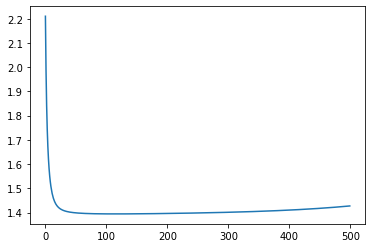

In [285]:
# plt.plot(np.arange(epochs), np.array(costs))
plt.plot(np.arange(len(costs)), np.array(costs))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

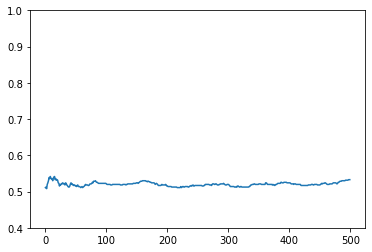

In [286]:
plt.plot(np.arange(len(accuracies)), np.array(accuracies))
axis = plt.gca()
axis.set_ylim([0.4, 1.])
plt.show

In [287]:
# test
print('################### testing ####################')
# load the model
if os.path.isfile('model.pickle'):
    with open('model.pickle', 'rb') as f:
        model = pickle.load(f)

# run the whole test data
samples = X_test.shape[0]
cost = 0
hit_count = 0
for i in tqdm(range(samples)):
    m_state = forward_pass(X_test[i])
    cost += part_cost(m_state['o3'], y_test[i])
    if np.argmax(m_state['o3']) == np.argmax(y_test[i]):
        hit_count += 1

# evaluate performance
cost = cost / samples
accuracy = float(hit_count) / float(samples)
print('cost:', cost, 'accuracy:', accuracy)

100%|██████████| 172/172 [00:00<00:00, 8139.41it/s]

################### testing ####################
cost: 1.5983537620599644 accuracy: 0.5174418604651163
